In [ ]:
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
# Necessary library import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
warnings.filterwarnings('ignore')

In [ ]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) # no limit on the number of columns
pd.set_option('display.max_rows', None)  # no limit on the number of rows
pd.set_option('display.max_colwidth', None) # no limit on the column width

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
df = pd.read_csv('/content/cic-ids2017_v1.csv')
df.shape

(75000, 60)

In [ ]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Avg Packet Size', 'Subflow Fwd Bytes',

In [ ]:
targets = ['Attack Type', 'status']
features = [col for col in df.columns if col not in targets]
df = shuffle(df, random_state=42)
X = df[features]
y = df[targets]
y = df['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# fit model on all training data
model = XGBClassifier(objective='binary:logistic', eval_metrics='logloss', tree_method='gpu_hist',random_state=42)
model.fit(X_train, y_train)

# predict on test data and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.70%


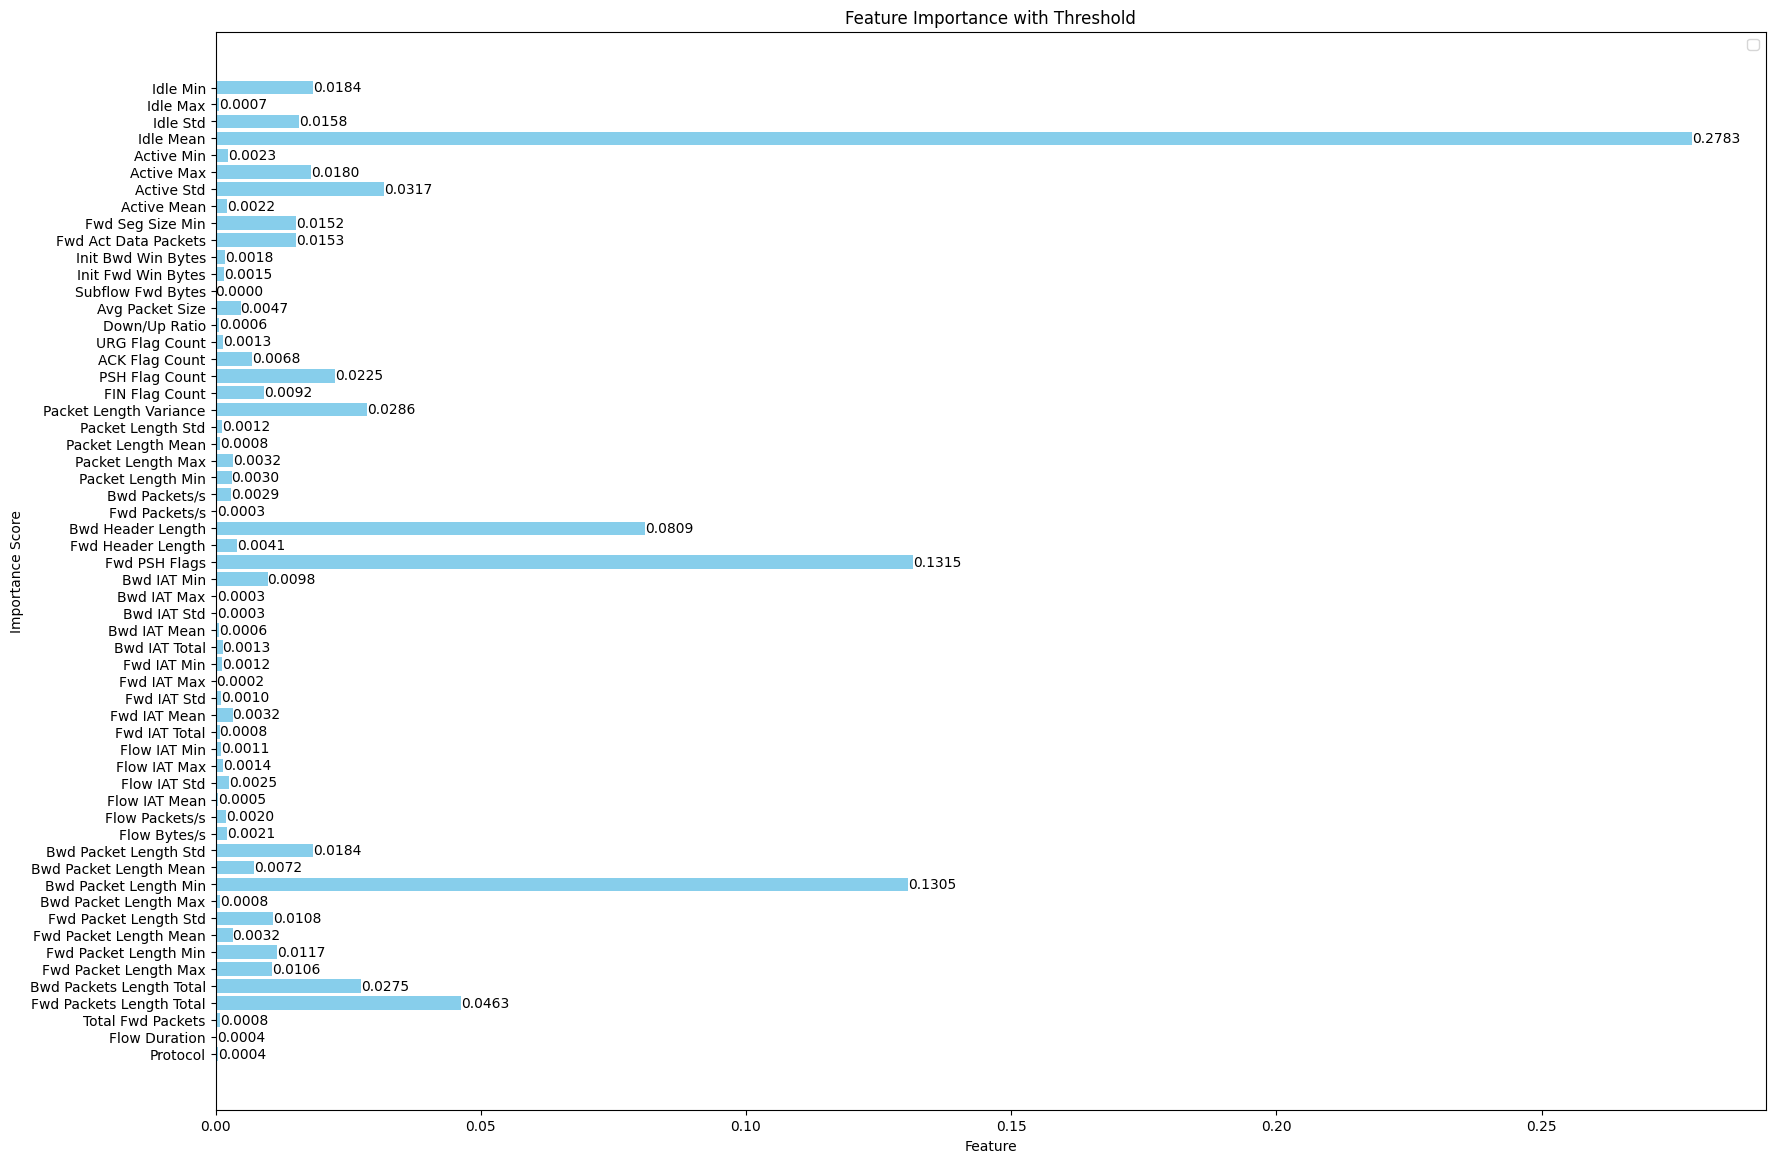

In [ ]:
feature_importance = pd.DataFrame({"Feature": features, "Importance": model.feature_importances_})

colors = ['skyblue']

plt.figure(figsize=(20, 14))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
for bar in bars:
  width = bar.get_width()
  plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance with Threshold")
plt.legend()
plt.show()

In [ ]:
%%time
# fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)

    # train model
    selection_model = XGBClassifier(objective='binary:logistic', eval_metrics='logloss', tree_method='gpu_hist',random_state=42)
    selection_model.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Thresh:{thresh:.4f}, n:{select_X_train.shape[1]}, Accuracy: {(accuracy*100.0):.2f}")

Thresh:0.0000, n:58, Accuracy: 99.70
Thresh:0.0002, n:57, Accuracy: 99.70
Thresh:0.0003, n:56, Accuracy: 99.72
Thresh:0.0003, n:55, Accuracy: 99.72
Thresh:0.0003, n:54, Accuracy: 99.69
Thresh:0.0004, n:53, Accuracy: 99.70
Thresh:0.0004, n:52, Accuracy: 99.67
Thresh:0.0005, n:51, Accuracy: 99.67
Thresh:0.0006, n:50, Accuracy: 99.70
Thresh:0.0006, n:49, Accuracy: 99.71
Thresh:0.0007, n:48, Accuracy: 99.68
Thresh:0.0008, n:47, Accuracy: 99.70
Thresh:0.0008, n:46, Accuracy: 99.71
Thresh:0.0008, n:45, Accuracy: 99.73
Thresh:0.0008, n:44, Accuracy: 99.70
Thresh:0.0010, n:43, Accuracy: 99.68
Thresh:0.0011, n:42, Accuracy: 99.69
Thresh:0.0012, n:41, Accuracy: 99.68
Thresh:0.0012, n:40, Accuracy: 99.61
Thresh:0.0013, n:39, Accuracy: 99.59
Thresh:0.0013, n:38, Accuracy: 99.62
Thresh:0.0014, n:37, Accuracy: 99.62
Thresh:0.0015, n:36, Accuracy: 99.60
Thresh:0.0018, n:35, Accuracy: 99.20
Thresh:0.0020, n:34, Accuracy: 98.38
Thresh:0.0021, n:33, Accuracy: 98.44
Thresh:0.0022, n:32, Accuracy: 98.44
T

In [ ]:
feature_importance = pd.DataFrame({"Feature": features, "Importance": model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

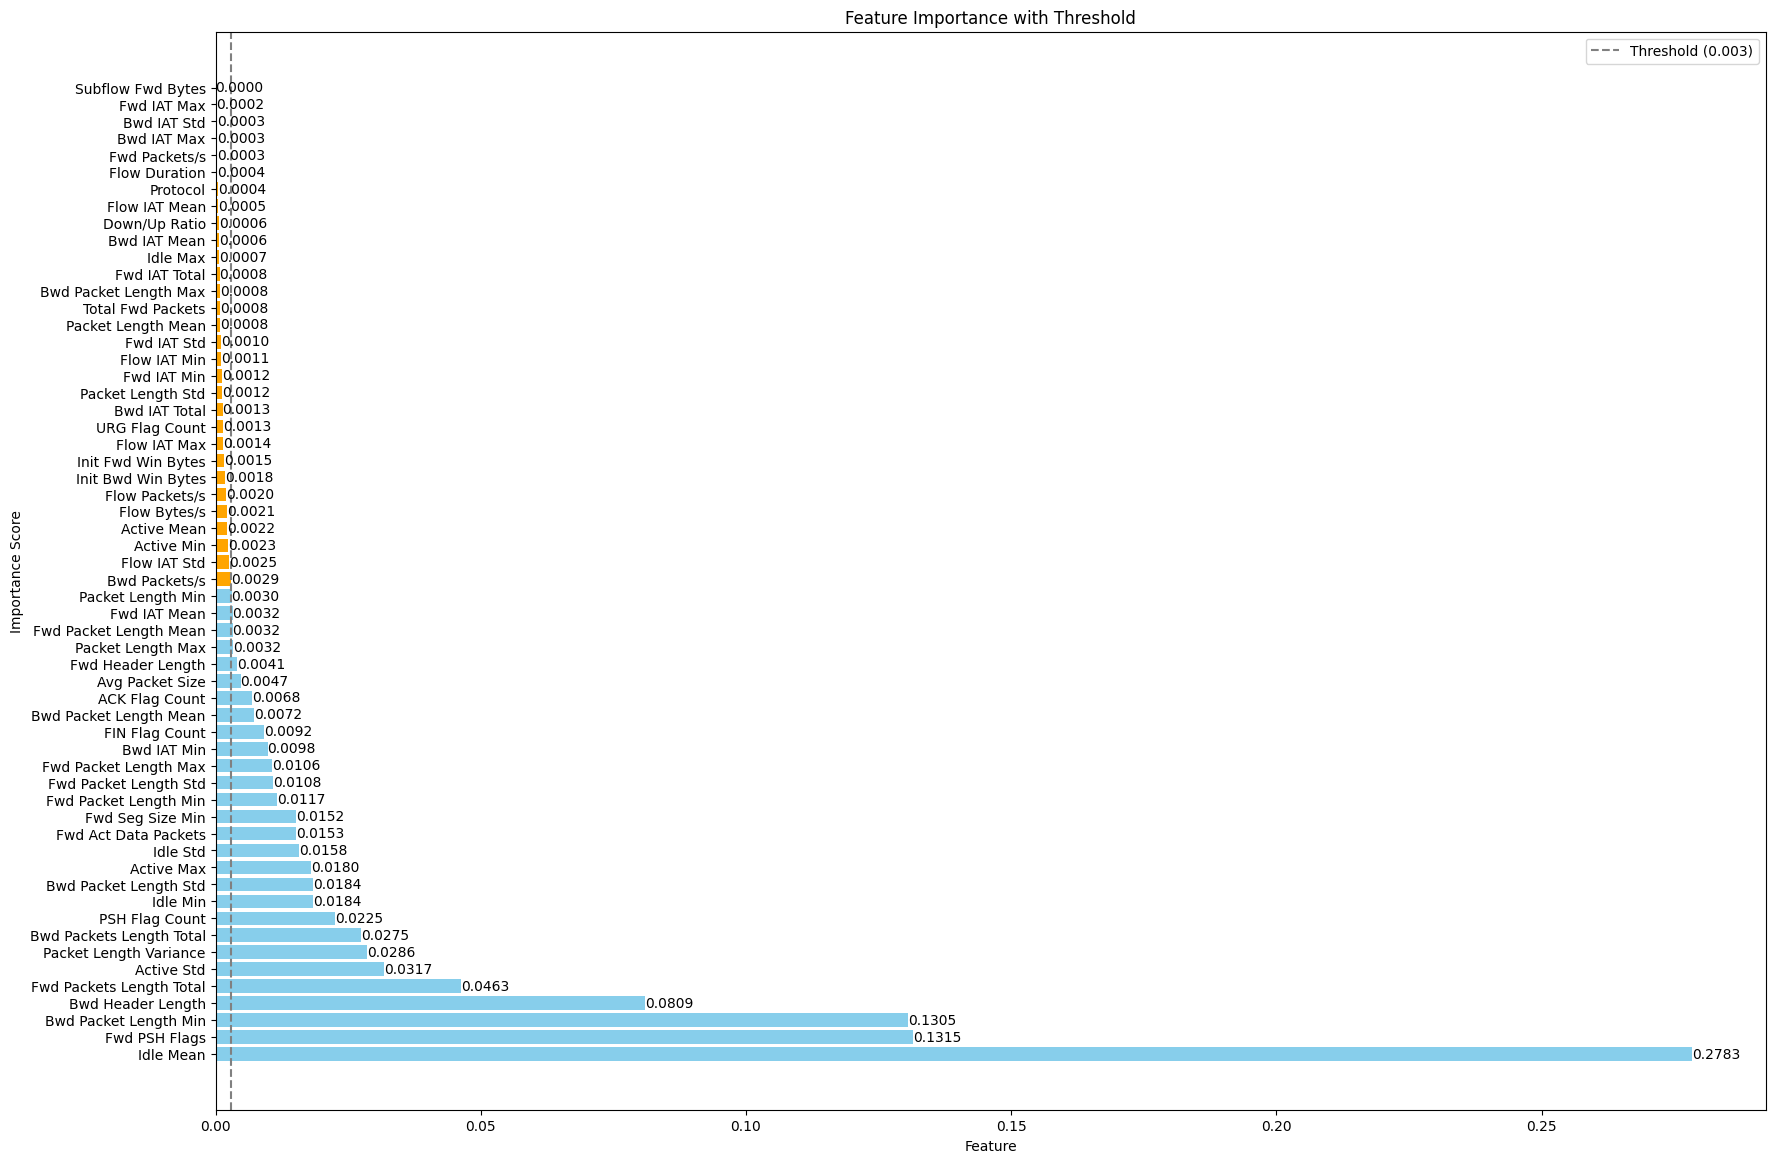

In [ ]:
threshold=0.0030
colors = ['skyblue' if imp>=threshold else 'orange' for imp in feature_importance['Importance']]

plt.figure(figsize=(20, 14))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
for bar in bars:
  width = bar.get_width()
  plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', va='center')

plt.axvline(x=threshold, color='gray', linestyle='--', label=f"Threshold ({threshold})")

plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance with Threshold")
plt.legend()
plt.show()

*****
## Training a final XGBoost Model

In [ ]:
targets = ['Attack Type', 'status']
features = [col for col in df.columns if col not in targets]
df = shuffle(df, random_state=42)
X = df[features]
y = df[targets]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
%%time
xgbc = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    tree_method='gpu_hist'
)
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.001],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgbc,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train['status'])

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
CPU times: user 2.72 s, sys: 349 ms, total: 3.07 s
Wall time: 1min 31s


In [ ]:
top_features = feature_importance['Feature'].iloc[:28].tolist()

# train/test split with selected features
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

best_params = grid_search.best_params_
xgb_classifier = XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    tree_method='gpu_hist'
  )

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_classifier.fit(X_train, y_train, eval_set=eval_set, verbose=True)

y_train_pred = xgb_classifier.predict(X_train)
y_val_pred = xgb_classifier.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

[0]	validation_0-mlogloss:1.58631	validation_1-mlogloss:1.58635
[1]	validation_0-mlogloss:1.56372	validation_1-mlogloss:1.56380
[2]	validation_0-mlogloss:1.54176	validation_1-mlogloss:1.54188
[3]	validation_0-mlogloss:1.52029	validation_1-mlogloss:1.52044
[4]	validation_0-mlogloss:1.49936	validation_1-mlogloss:1.49956
[5]	validation_0-mlogloss:1.47892	validation_1-mlogloss:1.47915
[6]	validation_0-mlogloss:1.45894	validation_1-mlogloss:1.45922
[7]	validation_0-mlogloss:1.43944	validation_1-mlogloss:1.43976
[8]	validation_0-mlogloss:1.42035	validation_1-mlogloss:1.42070
[9]	validation_0-mlogloss:1.40167	validation_1-mlogloss:1.40207
[10]	validation_0-mlogloss:1.38340	validation_1-mlogloss:1.38385
[11]	validation_0-mlogloss:1.36553	validation_1-mlogloss:1.36603
[12]	validation_0-mlogloss:1.34804	validation_1-mlogloss:1.34858
[13]	validation_0-mlogloss:1.33093	validation_1-mlogloss:1.33150
[14]	validation_0-mlogloss:1.31416	validation_1-mlogloss:1.31477
[15]	validation_0-mlogloss:1.29769	

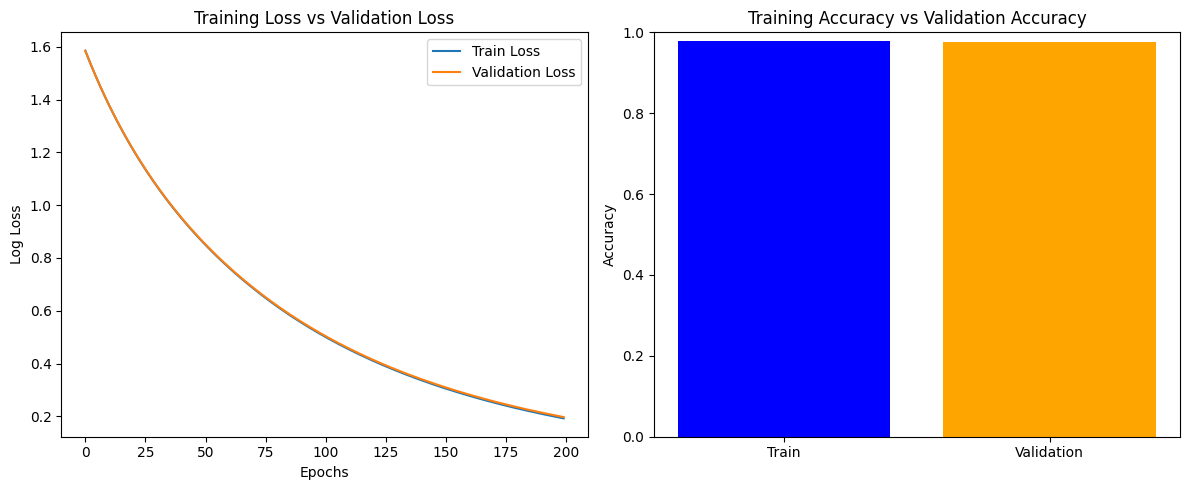

In [ ]:
results = final_model.evals_result()

# Plot Training Loss vs Cross-Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# Plot Training Accuracy vs Cross-Validation Accuracy
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Validation'], [train_acc, val_acc], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
y_test_pred = xgb_classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Acc: {test_acc:.4f}")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

Test Acc: 0.9768
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2243
           1       0.97      0.97      0.97      2284
           2       1.00      0.97      0.99      2251
           3       1.00      1.00      1.00      2239
           4       0.99      0.98      0.99      2233

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250

[[2161   61    1    3   17]
 [  71 2207    0    0    6]
 [  63    0 2186    0    2]
 [   0    1    0 2238    0]
 [  25   11    0    0 2197]]


In [ ]:
top_features

['Idle Mean',
 'Fwd PSH Flags',
 'Bwd Packet Length Min',
 'Bwd Header Length',
 'Fwd Packets Length Total',
 'Active Std',
 'Packet Length Variance',
 'Bwd Packets Length Total',
 'PSH Flag Count',
 'Idle Min',
 'Bwd Packet Length Std',
 'Active Max',
 'Idle Std',
 'Fwd Act Data Packets',
 'Fwd Seg Size Min',
 'Fwd Packet Length Min',
 'Fwd Packet Length Std',
 'Fwd Packet Length Max',
 'Bwd IAT Min',
 'FIN Flag Count',
 'Bwd Packet Length Mean',
 'ACK Flag Count',
 'Avg Packet Size',
 'Fwd Header Length',
 'Packet Length Max',
 'Fwd Packet Length Mean',
 'Fwd IAT Mean',
 'Packet Length Min']